In [393]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

class GalaxyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)
    
def get_dataloader(data, batch_size=32, shuffle=True):
    dataset = GalaxyDataset(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def fit_scaler(data):
    fluxes = data[:, :, 1:]  # Only fluxes (columns 1-10)
    scaler = StandardScaler()
    scaler.fit(fluxes.reshape(-1, fluxes.shape[-1]))
    return scaler

def normalize_data(data, scaler):
    wavelengths = data[:, :, 0:1]
    fluxes = data[:, :, 1:]
    normalized_fluxes = scaler.transform(fluxes.reshape(-1, fluxes.shape[-1]))
    return np.concatenate([wavelengths, normalized_fluxes.reshape(data.shape[0], data.shape[1], -1)], axis=2)

def inverse_normalize_data(data, scaler):
    fluxes = data[:, :, 1:]
    original_fluxes = scaler.inverse_transform(fluxes.reshape(-1, fluxes.shape[-1]))
    return original_fluxes.reshape(data.shape[0], data.shape[1], -1)


In [394]:
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, hidden_states):
        attn_weights = torch.softmax(self.attn(hidden_states), dim=1)
        context_vector = torch.sum(attn_weights * hidden_states, dim=1)
        return context_vector

class ComplexGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(ComplexGenerator, self).__init__()
        # Using a deeper RNN architecture with LSTMs
        self.rnn = nn.LSTM(latent_dim + 1, hidden_dim, batch_first=True, num_layers=5, bidirectional=True, dropout=0.3)
        self.attn = nn.MultiheadAttention(hidden_dim * 2, num_heads=4, dropout=0.3)  # Attention mechanism
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # Increased to handle bidirectional output
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln1 = nn.LayerNorm(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        # Additional layers for increased complexity
        self.residual_fc = nn.Sequential(
            nn.Linear(output_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        self.dropout = nn.Dropout(0.4)

    def forward(self, z, wavelengths):
        if wavelengths.dim() == 2:
            wavelengths = wavelengths.unsqueeze(-1)
        z = torch.cat([z, wavelengths], dim=-1)
        h, _ = self.rnn(z)

        # Apply attention mechanism
        h = h.permute(1, 0, 2)  # (seq_len, batch, hidden_dim * 2)
        h_attn, _ = self.attn(h, h, h)  # Self-attention
        h_attn = h_attn.permute(1, 0, 2)  # (batch, seq_len, hidden_dim * 2)

        h = self.dropout(h_attn)  # Apply dropout
        h = torch.relu(self.fc1(h))
        h = torch.relu(self.ln1(self.fc2(h)))
        output = self.fc3(h)

        # Apply residual connection
        output = output + self.residual_fc(output)
        return output

class ComplexDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexDiscriminator, self).__init__()
        # Deeper RNN with Bidirectional LSTM
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=5, dropout=0.3)
        self.attn = nn.MultiheadAttention(hidden_dim * 2, num_heads=4, dropout=0.3)  # Attention mechanism
        self.dropout = nn.Dropout(0.4)  # Increase dropout rate
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.ln1 = nn.LayerNorm(hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, output_dim)

        # Additional Residual Blocks
        self.residual_fc = nn.Sequential(
            nn.Linear(hidden_dim // 4, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 4)
        )

    def forward(self, x):
        h, _ = self.rnn(x)

        # Apply attention mechanism
        h = h.permute(1, 0, 2)  # (seq_len, batch, hidden_dim * 2)
        h_attn, _ = self.attn(h, h, h)  # Self-attention
        h_attn = h_attn.permute(1, 0, 2)  # (batch, seq_len, hidden_dim * 2)

        # Pool across time steps (mean) and pass through the rest of the network
        h = self.dropout(h_attn.mean(dim=1))  # Apply dropout after attention
        h = torch.relu(self.fc1(h))
        h = torch.relu(self.ln1(self.fc2(h)))
        h = torch.relu(self.ln2(self.fc3(h)))
        
        # Residual connection
        h = h + self.residual_fc(h)
        
        return torch.sigmoid(self.fc4(h))

class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(EmbeddingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.latent = nn.Linear(hidden_dim, latent_dim)
        nn.init.xavier_uniform_(self.latent.weight)
        nn.init.zeros_(self.latent.bias)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.latent(x)

class RecoveryNetwork(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(RecoveryNetwork, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, output_dim, batch_first=True)

    def forward(self, h):
        h = self.fc(h).unsqueeze(1)
        output, _ = self.rnn(h.repeat(1, h.shape[1], 1))
        return output

class TimeGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        self.device = device
        self.embedding_net = EmbeddingNetwork(input_dim, hidden_dim, latent_dim).to(device)
        self.recovery_net = RecoveryNetwork(latent_dim, hidden_dim, input_dim).to(device)
        self.generator_net = ComplexGenerator(latent_dim, hidden_dim, 10000).to(device)  # Predict 10 fluxes
        self.discriminator_net = ComplexDiscriminator(10000, hidden_dim, 1).to(device)


In [395]:
def gradient_penalty(discriminator, real_data, fake_data):
    """
    Compute the gradient penalty for WGAN-GP.

    Parameters:
    - discriminator: The discriminator network.
    - real_data: Real data samples.
    - fake_data: Fake data generated by the generator.

    Returns:
    - gradient_penalty: A scalar value for the gradient penalty term.
    """
    # Interpolate between real and fake data
    alpha = torch.rand(real_data.size(0), 1, 1).to(real_data.device)
    alpha = alpha.expand_as(real_data)
    
    # Create interpolated samples
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    
    # Compute the discriminator output for interpolated samples
    d_interpolates = discriminator(interpolates)
    
    # Compute gradients with respect to the interpolated samples
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Compute the L2 norm of the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [396]:
import torch.optim as optim

def train_timegan(train_loader, scaler, device, epochs=1000, lambda_gp=10):
    input_dim = 1  # Wavelength as input
    hidden_dim = 64
    latent_dim = 32
    sequence_length = 17
    
    timegan = TimeGAN(input_dim, hidden_dim, latent_dim, device)
    
    mse_loss = nn.MSELoss()
    discriminator_criterion = nn.BCEWithLogitsLoss()

    generator_optimizer = optim.Adam(timegan.generator_net.parameters(), lr=0.00005, betas=(0.5, 0.999))
    discriminator_optimizer = optim.Adam(timegan.discriminator_net.parameters(), lr=0.0001, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_data in train_loader:
            real_data = real_data.to(device)
            wavelengths = real_data[:, :, 0:1]

            # Discriminator Training (less frequent)
            for _ in range(1):
                noise = torch.randn(real_data.size(0), sequence_length, latent_dim).to(device)
                generated_data = timegan.generator_net(noise, wavelengths)
                
                real_labels = torch.ones(real_data.size(0), 1).to(device) * 0.9
                fake_labels = torch.zeros(real_data.size(0), 1).to(device) * 0.1
                
                real_data_noisy = real_data + 0.05 * torch.randn_like(real_data)
                generated_data_noisy = generated_data + 0.05 * torch.randn_like(generated_data)

                real_loss = discriminator_criterion(timegan.discriminator_net(real_data_noisy[:, :, 1:]), real_labels)
                fake_loss = discriminator_criterion(timegan.discriminator_net(generated_data_noisy.detach()), fake_labels)

                discriminator_loss = real_loss + fake_loss
                
                discriminator_optimizer.zero_grad()
                discriminator_loss.backward()
                discriminator_optimizer.step()

            # Generator Training (more frequent)
            for _ in range(2):
                noise = torch.randn(real_data.size(0), sequence_length, latent_dim).to(device)
                generated_data = timegan.generator_net(noise, wavelengths)
                generator_loss = mse_loss(generated_data, real_data[:, :, 1:])
                
                generator_optimizer.zero_grad()
                generator_loss.backward()
                generator_optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Generator Loss: {generator_loss.item():.4f}, Discriminator Loss: {discriminator_loss.item():.4f}")

    torch.save({
        'embedding_net': timegan.embedding_net.state_dict(),
        'recovery_net': timegan.recovery_net.state_dict(),
        'generator_net': timegan.generator_net.state_dict(),
        'discriminator_net': timegan.discriminator_net.state_dict(),
    }, 'new_timegan_weights.pth')

In [397]:
def predict_fluxes_for_wavelengths(timegan, wavelengths, scaler, device, latent_dim=32):
    wavelengths = wavelengths.to(device)
    noise = torch.randn(1, wavelengths.size(0), latent_dim).to(device)
    with torch.no_grad():
        generated_fluxes = timegan.generator_net(noise, wavelengths)
    generated_fluxes = generated_fluxes.detach().cpu().numpy().reshape(wavelengths.size(0), -1)
    generated_fluxes = scaler.inverse_transform(generated_fluxes)
    return generated_fluxes


In [398]:
import matplotlib.pyplot as plt

def plot_real_vs_generated(real_data, generated_data, scaler, num_samples=5):
    """
    Plots a comparison between real and generated data.
    
    Parameters:
    - real_data: torch.Tensor, the real data batch (shape: [batch_size, sequence_length, num_features])
    - generated_data: torch.Tensor, the generated data batch (shape: [batch_size, sequence_length, num_features])
    - scaler: fitted scaler for inverse normalization
    - num_samples: int, the number of samples to plot (default is 5)
    """
    
    # Move data to CPU if necessary
    real_data = real_data.detach().cpu().numpy()
    generated_data = generated_data.detach().cpu().numpy()
    
    # De-scale the generated data
    batch_size, sequence_length, num_features = generated_data.shape
    generated_data = generated_data.reshape(batch_size * sequence_length, num_features)
    generated_data = scaler.inverse_transform(generated_data)
    generated_data = generated_data.reshape(batch_size, sequence_length, num_features)
    
    # Ensure num_samples does not exceed batch size
    num_samples = min(num_samples, real_data.shape[0])
    
    # Plot each sample
    plt.figure(figsize=(10, 6 * num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        
        # Plot real data vs generated data for each feature
        plt.plot(real_data[i, :, 0], real_data[i, :, 2], label='Real', color='blue', alpha=0.7)
        print(real_data[i, :, 0].shape, generated_data[i, :, 1].shape)
        plt.scatter(real_data[i, :, 0], generated_data[i, :, 2], label='Generated', linestyle='dashed', color='red', alpha=0.7)
        
        plt.legend()
        plt.title(f'Sample {i + 1} - Real vs Generated')
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
    
    plt.tight_layout()
    plt.show()


In [399]:
def generate_flux_predictions(timegan, wavelengths, scaler, device, latent_dim=32):
    """
    Generate new flux predictions using the trained TimeGAN model.
    
    Parameters:
    - timegan: Trained TimeGAN model.
    - wavelengths: Tensor of wavelengths for which to generate predictions (shape: [sequence_length, 1]).
    - scaler: Fitted scaler used during training for normalization.
    - device: Device (CPU/GPU) on which the model is running.
    - latent_dim: Dimension of the noise vector used as input to the generator.
    
    Returns:
    - generated_fluxes: De-scaled predicted fluxes.
    """
    # Ensure wavelengths are on the correct device
    wavelengths = wavelengths.to(device).unsqueeze(0)  # Add batch dimension (1, seq_len, 1)
    
    # Generate a noise vector (batch_size=1 for a single prediction)
    noise = torch.randn(1, wavelengths.size(1), latent_dim).to(device)
    
    # Use the generator to produce predicted fluxes
    with torch.no_grad():
        generated_fluxes = timegan.generator_net(noise, wavelengths)
    
    # De-scale the generated data
    generated_fluxes = generated_fluxes.squeeze(0).detach().cpu().numpy()  # Remove batch dimension
    generated_fluxes = scaler.inverse_transform(generated_fluxes)
    
    return generated_fluxes


In [400]:
def generate_single_galaxy_flux(timegan, wavelengths, scaler, device, latent_dim=32):
    """
    Generate flux predictions for a single galaxy using the trained TimeGAN model.
    
    Parameters:
    - timegan: Trained TimeGAN model.
    - wavelengths: Tensor of wavelengths for which to generate predictions (shape: [sequence_length, 1]).
    - scaler: Fitted scaler used during training for normalization.
    - device: Device (CPU/GPU) on which the model is running.
    - latent_dim: Dimension of the noise vector used as input to the generator.
    
    Returns:
    - generated_fluxes: De-scaled predicted fluxes for a single galaxy.
    """
    # Ensure wavelengths are on the correct device
    wavelengths = wavelengths.to(device).unsqueeze(0)  # Add batch dimension (1, seq_len, 1)
    
    # Generate a noise vector (batch_size=1 for a single prediction)
    noise = torch.randn(1, wavelengths.size(1), latent_dim).to(device)
    
    # Use the generator to produce predicted fluxes
    with torch.no_grad():
        generated_fluxes = timegan.generator_net(noise, wavelengths)
    
    # De-scale the generated data
    generated_fluxes = generated_fluxes.squeeze(0).detach().cpu().numpy()  # Remove batch dimension
    generated_fluxes = scaler.inverse_transform(generated_fluxes)  # Inverse scaling
    
    return generated_fluxes


In [401]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(timegan, real_loader, scaler, device, latent_dim=32):
    mse_list = []
    mae_list = []

    timegan.generator_net.eval()  # Set model to evaluation mode

    for real_data in real_loader:
        real_data = real_data.to(device)
        real_wavelengths = real_data[:, :, 0:1]  # Extract real wavelengths
        real_fluxes = real_data[:, :, 1:]        # Extract real fluxes
        
        # Generate fluxes using the same wavelengths
        noise = torch.randn(real_data.size(0), real_data.size(1), latent_dim).to(device)
        generated_fluxes = timegan.generator_net(noise, real_wavelengths)
        
        # De-scale the generated and real fluxes
        real_fluxes = scaler.inverse_transform(real_fluxes.detach().cpu().numpy().reshape(-1, real_fluxes.shape[-1]))
        generated_fluxes = scaler.inverse_transform(generated_fluxes.detach().cpu().numpy().reshape(-1, generated_fluxes.shape[-1]))
        
        # Calculate evaluation metrics
        mse = mean_squared_error(real_fluxes, generated_fluxes)
        mae = mean_absolute_error(real_fluxes, generated_fluxes)

        mse_list.append(mse)
        mae_list.append(mae)
    
    avg_mse = sum(mse_list) / len(mse_list)
    avg_mae = sum(mae_list) / len(mae_list)

    print(f"Evaluation - Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}")


In [402]:
# Execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    df = pd.read_csv('../data/interpolated_spectra.csv').T
    df.reset_index(inplace=True)
    df.columns = range(len(df.columns))
    total_rows = len(df)
    sequence_length = 17
    num_features = 10001

    assert df.shape[1] == num_features, f"Expected {num_features} features, but got {df.shape[1]}"
    if total_rows % sequence_length == 0:
        num_samples = total_rows // sequence_length
    else:
        raise ValueError("The total number of rows is not divisible by sequence length. Please adjust the data.")

    data = df.values.astype(np.float64).reshape(num_samples, sequence_length, num_features)
    scaler = fit_scaler(data)
    train_loader = get_dataloader(data, batch_size=32)

    # Train the updated TimeGAN
    train_timegan(train_loader, scaler, device, epochs=100000)

Epoch [100/100000], Generator Loss: 6.5780, Discriminator Loss: 1.3671
Epoch [200/100000], Generator Loss: 4.7590, Discriminator Loss: 1.3152
Epoch [300/100000], Generator Loss: 3.5269, Discriminator Loss: 1.2735
Epoch [400/100000], Generator Loss: 2.8344, Discriminator Loss: 1.2425
Epoch [500/100000], Generator Loss: 2.4932, Discriminator Loss: 1.2107
Epoch [600/100000], Generator Loss: 2.3429, Discriminator Loss: 1.1831
Epoch [700/100000], Generator Loss: 2.2701, Discriminator Loss: 1.1619
Epoch [800/100000], Generator Loss: 1.9304, Discriminator Loss: 1.1451
Epoch [900/100000], Generator Loss: 1.6025, Discriminator Loss: 1.1340
Epoch [1000/100000], Generator Loss: 1.2553, Discriminator Loss: 1.1265
Epoch [1100/100000], Generator Loss: 0.9477, Discriminator Loss: 1.1213
Epoch [1200/100000], Generator Loss: 0.7357, Discriminator Loss: 1.3884
Epoch [1300/100000], Generator Loss: 0.5953, Discriminator Loss: 1.3881
Epoch [1400/100000], Generator Loss: 0.4814, Discriminator Loss: 1.3883
E

C:\Users\vasil\AppData\Local\Temp\ipykernel_9288\3956648598.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('new_timegan_weights.pth', map_locati

tensor([[[-0.8429],
         [-0.7056],
         [-0.5924],
         [-0.5320],
         [-0.3808],
         [-0.2604],
         [-0.1444],
         [ 0.0723],
         [ 0.1749],
         [ 0.2754],
         [ 0.4202],
         [ 0.9008],
         [ 1.3657],
         [ 1.4748],
         [ 1.7247],
         [ 1.9185],
         [ 2.0646]]], device='cuda:0')
(17,) (17,)


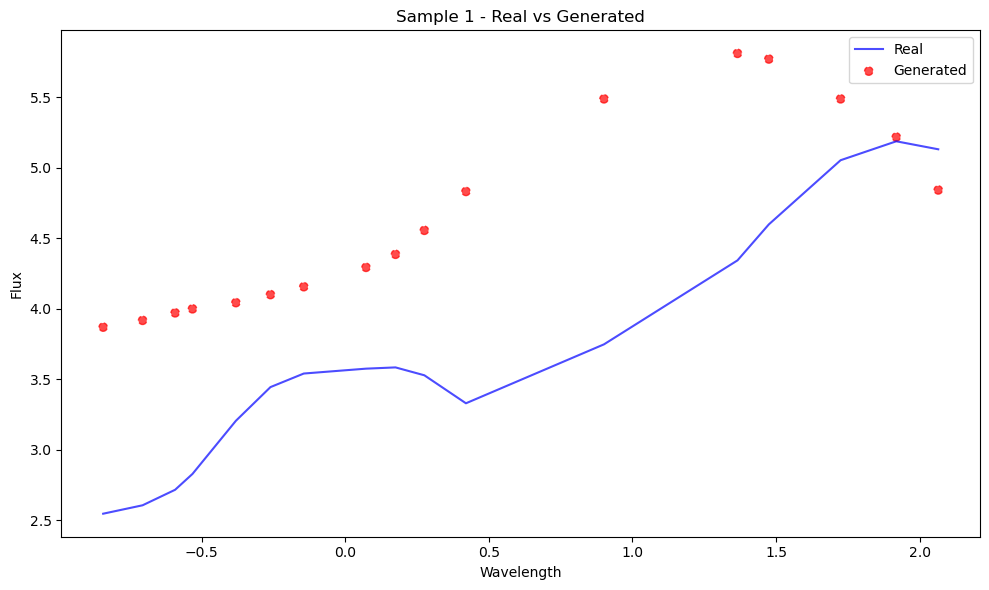

Evaluation - Average MSE: 0.0007, Average MAE: 0.0148


In [421]:
# Load the trained model weights
timegan = TimeGAN(1, 64, 32, device)
checkpoint = torch.load('new_timegan_weights.pth', map_location=device)
timegan.generator_net.load_state_dict(checkpoint['generator_net'])

# Get a batch of real data from the data loader
real_data_batch = next(iter(train_loader))
real_data_batch = real_data_batch[:32].to(device)  # Ensure batch size of 32

# Extract the wavelengths (0th column) from the real data batch
wavelengths = real_data_batch[0, :, 0:1].unsqueeze(0)  # Take only the first example and add batch dimension
print(wavelengths)
wavelengths = wavelengths.repeat(32, 1, 1)  # Repeat across batch dimension to match noise

# Generate data using both noise and the real wavelengths
noise = torch.randn(32, sequence_length, 32).to(device)
generated_data_batch = timegan.generator_net(noise, wavelengths)

# Visualize Real vs Generated Data
plot_real_vs_generated(real_data_batch[:, :, 0:], generated_data_batch, scaler, num_samples=5)
# Assuming you already have a DataLoader `real_loader` with your dataset
evaluate_model(timegan, train_loader, scaler, device)

Generated Fluxes for Single Galaxy: [[ -4.9972734    5.849107     3.8484647  ... -22.614471     5.303298
    0.16740918]
 [ -4.957427     5.897991     3.9117565  ... -22.7582       5.372359
    0.23528847]
 [ -4.7621403    6.0303125    3.9661243  ... -22.372889     5.5153923
    0.27760035]
 ...
 [ -1.1618348    7.9681706    5.5287027  ...  13.042184     7.4237795
    1.9395081 ]
 [ -1.1625265    8.047002     5.2150497  ...  10.541235     7.6051207
    1.7065983 ]
 [ -1.3136125    8.035313     4.848559   ...   8.142142     7.673303
    1.3823463 ]]


C:\Users\vasil\AppData\Local\Temp\ipykernel_9288\1172719456.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('new_timegan_weights.pth', map_locati

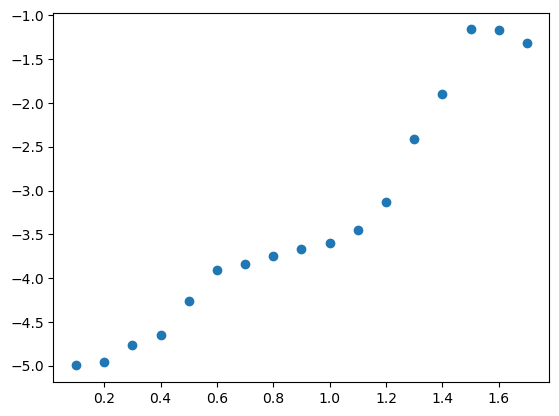

In [404]:
# Load your trained model weights
checkpoint = torch.load('new_timegan_weights.pth', map_location=device)
timegan = TimeGAN(1, 64, 32, device)
timegan.generator_net.load_state_dict(checkpoint['generator_net'])

# Example wavelengths to use for prediction (sequence length should match your data)
example_wavelengths = torch.tensor([
    [0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7], [0.8], [0.9], [1.0],
    [1.1], [1.2], [1.3], [1.4], [1.5], [1.6], [1.7]
])

# Generate flux predictions for a single galaxy
generated_fluxes = generate_single_galaxy_flux(timegan, example_wavelengths, scaler, device)
print("Generated Fluxes for Single Galaxy:", generated_fluxes)
plt.scatter(example_wavelengths,generated_fluxes[:,0])